# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Capstone Project 
### Business Objective
Predict whether an offer will be effective i.e the customer is incentivised to make a purchase because of an offer.

First we will work on importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

#% matplotlib inline
import sqlite3

from sqlalchemy import create_engine
import sklearn
import re
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from scipy.stats import randint

#pip install --upgrade nbstripout
#conda install seaborn==0.9.0

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

sns.set(rc={'figure.figsize':(11.7,8.27)})

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration
#### Offer Data

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
#Clean portfolio - split channel to multiple columns
master_channels = set(['web', 'email', 'mobile', 'social'])

# split the channel into different attribute
for i in master_channels:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
portfolio.head()

#add new field -offer available via multiple channels - most common offer will have value 4
portfolio['channel_reach']=portfolio['email']+portfolio['web']+portfolio['social']+portfolio['mobile']

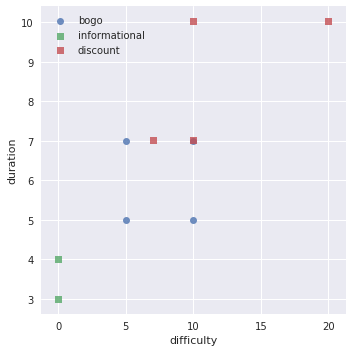

In [4]:
#Scatter plot order amount by age group
sns.lmplot( x="difficulty", y="duration", data=portfolio, fit_reg=False, hue='offer_type', legend=False,markers=["o", "s", ","])
plt.legend(loc='upper left')

There are a total of 10 offers with categorized as Informational, discount and BOGO types. Most offers are send via multiple platforms i.e web,email,mobile . The duration of the offers are variable and range between 3 days to 10 days.

#### Customer Data

In [5]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Age of the customers is distributed between 18 and 118 years old. The middle 50% of customers are 45 and 73 years old. The clear outlier here is customers with age of 118. Further analysis revealed that these customers did not have other relevant information such as Gender and Income . Therefore , I chose to remove this subset from the data for modeling.

In [9]:
#outliers in age
profile[profile['age']>=100].age.value_counts(dropna=False)

118    2175
100      12
101       5
Name: age, dtype: int64

In [10]:
profile[profile['age']>=100].nunique()

age                    3
became_member_on     954
gender                 3
id                  2192
income                15
dtype: int64

In [11]:
profile['gender'].value_counts(dropna=False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

Below is a snapshot of the distribution of customers by gender , overall there are more Male customers than Female customer. The number of Female customers start picking up around age 50 till about age 70 in contrast to the Male customers which has remains steady till about 40 years.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6e5539978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb6e54d9ef0>]], dtype=object)

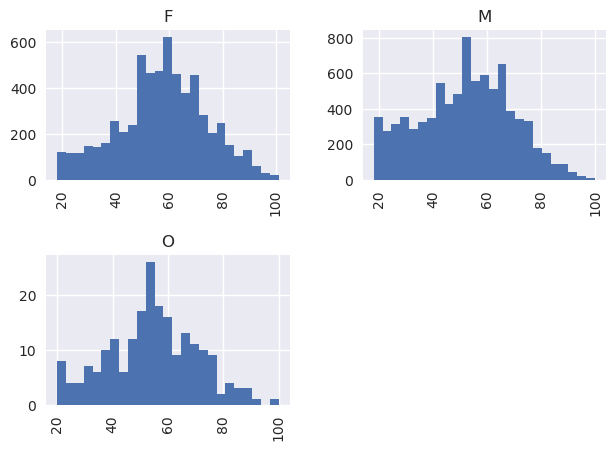

In [12]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
profile.age.hist(by=profile.gender,bins=25)

In terms of income distribution , there is a more varied distribution of income for Female customers. Across both groups the upper 25th percentile for income is at about $80K

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6e542c710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb6e53d10b8>]], dtype=object)

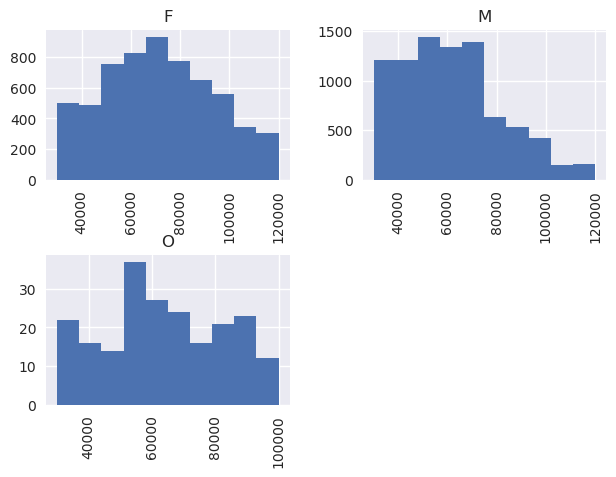

In [13]:
#income distribution
profile.income.hist(by=profile.gender)

In [14]:
bins = ([0,10,20,30,40,50,60,70,80,90,100,110,120])
#ageGroup = profile.groupby(pd.cut(profile['age'], bins=bins)).size()
profile['agegroup'] =pd.cut(profile['age'], bins=bins)
profile.dtypes

age                    int64
became_member_on       int64
gender                object
id                    object
income               float64
agegroup            category
dtype: object

In [15]:
# missing values
print("missing income",profile.income.isnull().sum()/profile.shape[0])
print("missing gender",profile.gender.isnull().sum()/profile.shape[0])
print("missing person",profile.id.isnull().sum()/profile.shape[0])
#12% missing values have are having invalid value for age, missing value for income and gender
profile[profile['gender'].isnull()]
print("check gender for age=118",profile[profile['age']==118].gender.unique())
print("check income for age=118",profile[profile['age']==118].income.unique())
#force median values ??

missing income 0.127941176471
missing gender 0.127941176471
missing person 0.0
check gender for age=118 [None]
check income for age=118 [ nan]


In [16]:
transcript.value.unique
transcript.event.unique()
#did the offer influence the user ?
# Desired workflow 
#'offer received', 'offer viewed', 'transaction', 'offer completed'
#no influence
#'offer received', 'transaction', 'offer completed'

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
#a03223e636434f42ac4c3df47e8bac43
transcript.loc[transcript['person'] == '0aea37c300ba4262b523881c7112484d']

,event,person,time,value
7487,offer received,0aea37c300ba4262b523881c7112484d,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
30477,transaction,0aea37c300ba4262b523881c7112484d,48,{'amount': 0.6000000000000001}
41535,transaction,0aea37c300ba4262b523881c7112484d,96,{'amount': 5.21}
41536,offer completed,0aea37c300ba4262b523881c7112484d,96,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
42763,transaction,0aea37c300ba4262b523881c7112484d,102,{'amount': 3.94}
60696,offer received,0aea37c300ba4262b523881c7112484d,168,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
95858,transaction,0aea37c300ba4262b523881c7112484d,252,{'amount': 5.1}
103353,transaction,0aea37c300ba4262b523881c7112484d,288,{'amount': 5.49}
142764,transaction,0aea37c300ba4262b523881c7112484d,378,{'amount': 3.67}
149916,transaction,0aea37c300ba4262b523881c7112484d,402,{'amount': 4.64}


In [19]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
# function to chan
def column_values_encode (dataframe, column_list):
    for column in column_list:
        column_dummies = pd.get_dummies(dataframe[column])
        dataframe = dataframe.drop(column, axis = 1)
        dataframe = dataframe.join(column_dummies)
    return dataframe

In [20]:
columns = ['event']
transcript = column_values_encode(transcript, columns)
transcript.columns

Index(['person', 'time', 'value', 'offer completed', 'offer received', 'offer viewed', 'transaction'], dtype='object')

In [21]:
#Clean up transcript 
#'offer received', 'offer viewed', 'transaction', 'offer completed'

df_trx = transcript[transcript['transaction'] == 1]
df_offr_rcv = transcript[transcript['offer received'] == 1]
df_offr_vw = transcript[transcript['offer viewed'] == 1]
df_offr_comp = transcript[transcript['offer completed'] == 1]
df_trx = pd.concat([df_trx, df_trx['value'].apply(pd.Series)], axis=1)
df_offr_rcv = pd.concat([df_offr_rcv, df_offr_rcv['value'].apply(pd.Series)], axis=1)
df_offr_vw = pd.concat([df_offr_vw, df_offr_vw['value'].apply(pd.Series)], axis=1)
df_offr_comp = pd.concat([df_offr_comp, df_offr_comp['value'].apply(pd.Series)], axis=1)

In [22]:
#rename colums to be consistent
df_offr_vw.rename(columns={'person':'customer_id','offer id': 'offer_id','offer viewed':'offer_viewed'}, inplace=True)
df_offr_rcv.rename(columns={'person':'customer_id','offer id': 'offer_id','offer received':'offer_received'}, inplace=True)
df_offr_comp.rename(columns={'person':'customer_id','offer id': 'offer_id','offer completed':'offer_completed'}, inplace=True)
df_trx.rename(columns={'person':'customer_id'}, inplace=True)
portfolio.rename(columns={'id': 'offer_id','difficulty':'qualifying_amount'}, inplace=True)
profile.rename(columns={'id': 'customer_id'}, inplace=True)
profile.head(5)

,age,became_member_on,gender,customer_id,income,agegroup
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,"(110, 120]"
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,"(50, 60]"
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,"(110, 120]"
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,"(70, 80]"
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,"(110, 120]"


### Processing transaction data in SQL


In [23]:
df_offr_comp_db=df_offr_comp[['customer_id','time','offer_completed','offer_id','reward']]
df_offr_vw_db=df_offr_vw[['customer_id','time','offer_viewed','offer_id']]
df_offr_rcv_db=df_offr_rcv[['customer_id','time','offer_received','offer_id']]
df_trx_db=df_trx[['customer_id','time','transaction','amount']]
df_offers_db=portfolio[['offer_id','offer_type','qualifying_amount','duration','reward','web','social','mobile','email','channel_reach']]
conn = sqlite3.connect('sb_capstone_a.db', timeout=10)
cursor = conn.cursor()


In [34]:
#https://www.tutorialspoint.com/python_data_access/python_sqlite_drop_table.htm
df_offr_comp_db=df_offr_comp[['customer_id','time','offer_completed','offer_id','reward']]
df_offr_vw_db=df_offr_vw[['customer_id','time','offer_viewed','offer_id']]
df_offr_rcv_db=df_offr_rcv[['customer_id','time','offer_received','offer_id']]
df_trx_db=df_trx[['customer_id','time','transaction','amount']]
df_offers_db=portfolio[['offer_id','offer_type','qualifying_amount','duration','reward','web','social','mobile','email','channel_reach']]
conn = sqlite3.connect('sb_capstone.db', timeout=10)
cursor = conn.cursor()
#Dropping df_offr_comp table if already exists
cursor.execute("DROP TABLE df_offr_comp")
cursor.execute("DROP TABLE df_offr_vw")
cursor.execute("DROP TABLE df_offr_rcv")
cursor.execute("DROP TABLE df_trx")
cursor.execute("DROP TABLE df_offers")
cursor.execute("DROP TABLE df_offr_rcv_view")
cursor.execute("DROP TABLE df_offr_rcv_view_trx")
print("Table dropped... ")



Table dropped... 


In [35]:
#Commit your changes in the database
#conn.commit()

#Closing the connection
#conn.close()
#engine = create_engine('sqlite:///capstone.db')
# load data into db
df_offr_comp_db.to_sql('df_offr_comp', conn, index=False)
df_offr_vw_db.to_sql('df_offr_vw', conn, index=False)
df_offr_rcv_db.to_sql('df_offr_rcv', conn, index=False)
df_offers_db.to_sql('df_offers', conn, index=False)
df_trx_db.to_sql('df_trx', conn, index=False)

# creating dataframes
df_r=pd.read_sql('SELECT * FROM df_offr_vw', con = conn)
df_v=pd.read_sql('SELECT * FROM df_offr_rcv', con = conn)
df_c=pd.read_sql('SELECT * FROM df_offr_comp', con = conn)
df_t=pd.read_sql('SELECT * FROM df_trx', con = conn)
df_offr=pd.read_sql('SELECT * FROM df_offers', con = conn)

#### Effective Offer
If a customer receives an offer then views it offer and subsequently spends the required amount within the validity period, this is considered an effective offer.

In [36]:
sql = '''SELECT r.customer_id,round(r.time/24) as rcv_time_days,r.time as rcv_time,r.offer_received,r.offer_id,round(v.time/24) vw_time_days,v.time as view_time,v.offer_viewed,round(c.time/24) comp_time_days,c.time as completion_time,c.offer_completed,offer_type,qualifying_amount,duration,web,social,mobile,email,channel_reach,round(r.time/24)+duration max_offer_duration_days,r.time+(duration*24) max_offer_duration_hours 
         from df_offr_rcv r 
            LEFT JOIN df_offr_vw v 
                ON r.customer_id = v.customer_id 
                and r.offer_id = v.offer_id
            LEFT JOIN df_offr_comp c 
                ON r.customer_id = c.customer_id 
                and r.offer_id = c.offer_id
            LEFT JOIN df_offers o
                ON r.offer_id=o.offer_id'''
#Executing the query
cursor.execute(sql)
#Fetching 1st row from the table
#result = cursor.fetchall();
#print(result)

In [37]:
df_offr_rcv_view=pd.read_sql(sql, con = conn)

In [38]:
df_offr_rcv_view['rnum']=df_offr_rcv_view.groupby(['customer_id','offer_id'])['rcv_time'].rank(method="first", ascending=True)
df_offr_rcv_view.head()

,customer_id,rcv_time_days,rcv_time,offer_received,offer_id,vw_time_days,view_time,offer_viewed,comp_time_days,completion_time,offer_completed,offer_type,qualifying_amount,duration,web,social,mobile,email,channel_reach,max_offer_duration_days,max_offer_duration_hours,rnum
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6.0,1.0,5.0,132.0,1.0,bogo,5,7,1,0,1,1,3,7.0,168,1.0
1,a03223e636434f42ac4c3df47e8bac43,0.0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,6.0,1.0,NaN,NaN,NaN,discount,20,10,1,0,0,1,2,10.0,240,1.0
2,a03223e636434f42ac4c3df47e8bac43,0.0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,26.0,624.0,1.0,NaN,NaN,NaN,discount,20,10,1,0,0,1,2,10.0,240,2.0
3,e2127556f4f64592b11af22de27a7932,0.0,0,1,2906b810c7d4411798c6938adc9daaa5,0.0,18.0,1.0,NaN,NaN,NaN,discount,10,7,1,0,1,1,3,7.0,168,1.0
4,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,0,1,fafdcd668e3743c1bb461111dcafc2a4,0.0,12.0,1.0,NaN,NaN,NaN,discount,10,10,1,1,1,1,4,10.0,240,1.0


In [39]:
df_offr_rcv_view.to_sql('df_offr_rcv_view', conn, index=False)

In [40]:
sql_1 = '''
        --with cte as (select * from df_offr_rcv_view r where r.offer_type='informational')
        SELECT r.*,min(round(t.time/24)) as min_trx_time_d,min(t.time) as min_trx_time,max(round(t.time/24)) as max_trx_time_d,max(t.time) as max_trx_time,sum(t.amount) total_order_amount,max(case when t.amount>0 then 1 else 0 end) as trx_completed,case when view_time<=time and (offer_completed=1 or t.amount>1) then 1 else 0 end as effective_offer
         from df_offr_rcv_view r
         LEFT JOIN df_trx t
         ON r.customer_id = t.customer_id 
                and t.time between r.rcv_time and r.max_offer_duration_hours
                and r.rnum=1
         --where r.customer_id in ('78afa995795e4d85b5d9ceeca43f5fef')
         group by r.customer_id,r.rcv_time_days,r.rcv_time,r.offer_received,r.vw_time_days,r.view_time,r.offer_viewed,r.comp_time_days,r.completion_time,r.offer_completed,r.offer_type,r.qualifying_amount,duration,web,social,mobile,email,channel_reach,r.max_offer_duration_days
         order by customer_id,r.rcv_time
         '''
#Executing the query
cursor.execute(sql_1)
#Fetching 1st row from the table
result = cursor.fetchall();
#print(result)

In [41]:
df_offr_rcv_view_trx=pd.read_sql(sql_1, con = conn)
df_offr_rcv_view_trx.to_sql('df_offr_rcv_view_trx', conn, index=False)
df_offr_rcv_view_trx.head()

,customer_id,rcv_time_days,rcv_time,offer_received,offer_id,vw_time_days,view_time,offer_viewed,comp_time_days,completion_time,offer_completed,offer_type,qualifying_amount,duration,web,social,mobile,email,channel_reach,max_offer_duration_days,max_offer_duration_hours,rnum,min_trx_time_d,min_trx_time,max_trx_time_d,max_trx_time,total_order_amount,trx_completed,effective_offer
0,0009655768c64bdeb2e877511632db8f,7.0,168,1,5a8bc65990b245e5a138643cd4eb9837,8.0,192.0,1.0,NaN,NaN,NaN,informational,0,3,0,1,1,1,3,10.0,240,1.0,9.0,228.0,9.0,228.0,22.16,1,1
1,0009655768c64bdeb2e877511632db8f,14.0,336,1,3f207df678b143eea3cee63160fa8bed,15.0,372.0,1.0,NaN,NaN,NaN,informational,0,4,1,0,1,1,3,18.0,432,1.0,17.0,414.0,17.0,414.0,8.57,1,1
2,0009655768c64bdeb2e877511632db8f,17.0,408,1,f19421c1d4aa40978ebb69ca19b0e20d,19.0,456.0,1.0,17.0,414.0,1.0,bogo,5,5,1,1,1,1,4,22.0,528,1.0,17.0,414.0,22.0,528.0,22.68,1,0
3,0009655768c64bdeb2e877511632db8f,21.0,504,1,fafdcd668e3743c1bb461111dcafc2a4,22.0,540.0,1.0,22.0,528.0,1.0,discount,10,10,1,1,1,1,4,31.0,744,1.0,22.0,528.0,29.0,696.0,96.87,1,0
4,0009655768c64bdeb2e877511632db8f,24.0,576,1,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,24.0,576.0,1.0,discount,10,7,1,0,1,1,3,31.0,744,1.0,24.0,576.0,29.0,696.0,69.20,1,0


### Business Rules :
    - If a transaction for a customer can be attributed to different offers (BOGO , Discount, Informational) based on amount and validity time frame, credit is given to the first offer.
    - If transactions for a customer map can be attributed to multiple offers of the same kind based on amount and validity time frame , credit is given to the first offer.

In [42]:
# If effective offer then set 1 for offer completed - this is applicable for informational offers
df_offr_rcv_view_trx.loc[df_offr_rcv_view_trx.effective_offer ==1, 'offer_completed'] = 1
# Set offer completion time for informational offers
df_offr_rcv_view_trx.loc[df_offr_rcv_view_trx.offer_type=='informational', 'completion_time'] = df_offr_rcv_view_trx['max_trx_time']
df_offr_rcv_view_trx.loc[df_offr_rcv_view_trx.offer_type=='informational', 'comp_time_days'] = df_offr_rcv_view_trx['max_trx_time']/24

# Replace missing values for the offer event type fields
df_offr_rcv_view_trx.fillna({x:0 for x in ['offer_received','offer_viewed','offer_completed','trx_completed','total_order_amount']}, inplace=True)

##Duplicate transaction
df_offr_rcv_view['rnum']=df_offr_rcv_view.groupby(['customer_id','offer_id'])['rcv_time'].rank(method="first", ascending=True)
df_offr_rcv_view.head()

# Re-arranging fields
df_offr_rcv_view_trx=df_offr_rcv_view_trx[['customer_id','effective_offer','total_order_amount','offer_id','offer_type','qualifying_amount','duration','rcv_time_days','vw_time_days','comp_time_days','min_trx_time_d','max_trx_time_d','rcv_time','view_time','completion_time','web','social','mobile','email','channel_reach','max_offer_duration_days','max_offer_duration_hours','min_trx_time','max_trx_time','offer_received','offer_viewed','offer_completed','trx_completed','rnum']]
df_offr_rcv_view_trx.head(5)

,customer_id,effective_offer,total_order_amount,offer_id,offer_type,qualifying_amount,duration,rcv_time_days,vw_time_days,comp_time_days,min_trx_time_d,max_trx_time_d,rcv_time,view_time,completion_time,web,social,mobile,email,channel_reach,max_offer_duration_days,max_offer_duration_hours,min_trx_time,max_trx_time,offer_received,offer_viewed,offer_completed,trx_completed,rnum
0,0009655768c64bdeb2e877511632db8f,1,22.16,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,7.0,8.0,9.50,9.0,9.0,168,192.0,228.0,0,1,1,1,3,10.0,240,228.0,228.0,1,1.0,1.0,1,1.0
1,0009655768c64bdeb2e877511632db8f,1,8.57,3f207df678b143eea3cee63160fa8bed,informational,0,4,14.0,15.0,17.25,17.0,17.0,336,372.0,414.0,1,0,1,1,3,18.0,432,414.0,414.0,1,1.0,1.0,1,1.0
2,0009655768c64bdeb2e877511632db8f,0,22.68,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,17.0,19.0,17.00,17.0,22.0,408,456.0,414.0,1,1,1,1,4,22.0,528,414.0,528.0,1,1.0,1.0,1,1.0
3,0009655768c64bdeb2e877511632db8f,0,96.87,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,21.0,22.0,22.00,22.0,29.0,504,540.0,528.0,1,1,1,1,4,31.0,744,528.0,696.0,1,1.0,1.0,1,1.0
4,0009655768c64bdeb2e877511632db8f,0,69.20,2906b810c7d4411798c6938adc9daaa5,discount,10,7,24.0,NaN,24.00,24.0,29.0,576,NaN,576.0,1,0,1,1,3,31.0,744,576.0,696.0,1,0.0,1.0,1,1.0


In [43]:
df_offr_rcv_view_trx.loc[df_offr_rcv_view_trx.customer_id=='00116118485d4dfda04fdbaba9a87b5c'].head(10)

,customer_id,effective_offer,total_order_amount,offer_id,offer_type,qualifying_amount,duration,rcv_time_days,vw_time_days,comp_time_days,min_trx_time_d,max_trx_time_d,rcv_time,view_time,completion_time,web,social,mobile,email,channel_reach,max_offer_duration_days,max_offer_duration_hours,min_trx_time,max_trx_time,offer_received,offer_viewed,offer_completed,trx_completed,rnum
5,00116118485d4dfda04fdbaba9a87b5c,0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,7.0,9.0,NaN,NaN,NaN,168,216.0,NaN,1,1,1,1,4,12.0,288,NaN,NaN,1,1.0,0.0,0,1.0
6,00116118485d4dfda04fdbaba9a87b5c,0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,7.0,26.0,NaN,NaN,NaN,168,630.0,NaN,1,1,1,1,4,12.0,288,NaN,NaN,1,1.0,0.0,0,2.0
7,00116118485d4dfda04fdbaba9a87b5c,0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,24.0,9.0,NaN,NaN,NaN,576,216.0,NaN,1,1,1,1,4,29.0,696,NaN,NaN,1,1.0,0.0,0,3.0
8,00116118485d4dfda04fdbaba9a87b5c,0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,24.0,26.0,NaN,NaN,NaN,576,630.0,NaN,1,1,1,1,4,29.0,696,NaN,NaN,1,1.0,0.0,0,4.0


In [44]:
#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()

In [45]:
print("offer receive:", df_offr_rcv_view_trx[df_offr_rcv_view_trx['offer_received']==1].shape)
print("offer viewed:", df_offr_rcv_view_trx[df_offr_rcv_view_trx['offer_viewed']==1].shape)
print("offer completed:", df_offr_rcv_view_trx[df_offr_rcv_view_trx['offer_completed']==1].shape)
print("transaction:", df_offr_rcv_view_trx[df_offr_rcv_view_trx['trx_completed']==1].shape)
#df_trx[df_trx['person']==id]
#['person', 'time', 'value', 'offer completed', 'offer received','offer viewed', 'transaction']

offer receive: (113934, 29)
offer viewed: (97380, 29)
offer completed: (75374, 29)
transaction: (49468, 29)


In [46]:
## End SQL Processing # Doesnt work 

In [47]:
#Test Users to spotcheck
#id='78afa995795e4d85b5d9ceeca43f5fef'
#id='e2127556f4f64592b11af22de27a7932'
id='0009655768c64bdeb2e877511632db8f'
#id='ffaecba5bbb14cffb04c2490d18eee7e'
#id='01873cc8de734961949af7c04b2e9872'
#id='0193c118afe84208b33ffeb1dcb277d8'
#id='68617ca6246f4fbc85e91a2a49552598'
#id='a03223e636434f42ac4c3df47e8bac43'
#id='0009655768c64bdeb2e877511632db8f'

df_offr_rcv_view_trx[df_offr_rcv_view_trx['customer_id']==id]

,customer_id,effective_offer,total_order_amount,offer_id,offer_type,qualifying_amount,duration,rcv_time_days,vw_time_days,comp_time_days,min_trx_time_d,max_trx_time_d,rcv_time,view_time,completion_time,web,social,mobile,email,channel_reach,max_offer_duration_days,max_offer_duration_hours,min_trx_time,max_trx_time,offer_received,offer_viewed,offer_completed,trx_completed,rnum
0,0009655768c64bdeb2e877511632db8f,1,22.16,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,7.0,8.0,9.50,9.0,9.0,168,192.0,228.0,0,1,1,1,3,10.0,240,228.0,228.0,1,1.0,1.0,1,1.0
1,0009655768c64bdeb2e877511632db8f,1,8.57,3f207df678b143eea3cee63160fa8bed,informational,0,4,14.0,15.0,17.25,17.0,17.0,336,372.0,414.0,1,0,1,1,3,18.0,432,414.0,414.0,1,1.0,1.0,1,1.0
2,0009655768c64bdeb2e877511632db8f,0,22.68,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,17.0,19.0,17.00,17.0,22.0,408,456.0,414.0,1,1,1,1,4,22.0,528,414.0,528.0,1,1.0,1.0,1,1.0
3,0009655768c64bdeb2e877511632db8f,0,96.87,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,21.0,22.0,22.00,22.0,29.0,504,540.0,528.0,1,1,1,1,4,31.0,744,528.0,696.0,1,1.0,1.0,1,1.0
4,0009655768c64bdeb2e877511632db8f,0,69.20,2906b810c7d4411798c6938adc9daaa5,discount,10,7,24.0,NaN,24.00,24.0,29.0,576,NaN,576.0,1,0,1,1,3,31.0,744,576.0,696.0,1,0.0,1.0,1,1.0


In [48]:
##Clean up Duplicate transaction -multiple offers receiving credits for same transaction , give priority to first offer
df_offr_rcv_view_trx['dup_trx']=df_offr_rcv_view_trx.groupby(['customer_id','min_trx_time_d','min_trx_time_d','total_order_amount'])['rcv_time'].rank(method="first", ascending=True)

df_offr_rcv_view_trx.loc[(df_offr_rcv_view_trx['dup_trx'] >1) ,'total_order_amount'] = 0
df_offr_rcv_view_trx.loc[(df_offr_rcv_view_trx['total_order_amount'] == 0) ,'effective_offer'] = 0

df_offr_rcv_view_trx[df_offr_rcv_view_trx['customer_id']==id]

,customer_id,effective_offer,total_order_amount,offer_id,offer_type,qualifying_amount,duration,rcv_time_days,vw_time_days,comp_time_days,min_trx_time_d,max_trx_time_d,rcv_time,view_time,completion_time,web,social,mobile,email,channel_reach,max_offer_duration_days,max_offer_duration_hours,min_trx_time,max_trx_time,offer_received,offer_viewed,offer_completed,trx_completed,rnum,dup_trx
0,0009655768c64bdeb2e877511632db8f,1,22.16,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,7.0,8.0,9.50,9.0,9.0,168,192.0,228.0,0,1,1,1,3,10.0,240,228.0,228.0,1,1.0,1.0,1,1.0,1.0
1,0009655768c64bdeb2e877511632db8f,1,8.57,3f207df678b143eea3cee63160fa8bed,informational,0,4,14.0,15.0,17.25,17.0,17.0,336,372.0,414.0,1,0,1,1,3,18.0,432,414.0,414.0,1,1.0,1.0,1,1.0,1.0
2,0009655768c64bdeb2e877511632db8f,0,22.68,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,17.0,19.0,17.00,17.0,22.0,408,456.0,414.0,1,1,1,1,4,22.0,528,414.0,528.0,1,1.0,1.0,1,1.0,1.0
3,0009655768c64bdeb2e877511632db8f,0,96.87,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,21.0,22.0,22.00,22.0,29.0,504,540.0,528.0,1,1,1,1,4,31.0,744,528.0,696.0,1,1.0,1.0,1,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,0,69.20,2906b810c7d4411798c6938adc9daaa5,discount,10,7,24.0,NaN,24.00,24.0,29.0,576,NaN,576.0,1,0,1,1,3,31.0,744,576.0,696.0,1,0.0,1.0,1,1.0,1.0


In [49]:
df_offr_rcv_view_trx.columns


Index(['customer_id', 'effective_offer', 'total_order_amount', 'offer_id', 'offer_type', 'qualifying_amount', 'duration', 'rcv_time_days', 'vw_time_days', 'comp_time_days', 'min_trx_time_d', 'max_trx_time_d', 'rcv_time', 'view_time', 'completion_time', 'web', 'social', 'mobile', 'email', 'channel_reach', 'max_offer_duration_days', 'max_offer_duration_hours', 'min_trx_time', 'max_trx_time', 'offer_received', 'offer_viewed', 'offer_completed', 'trx_completed', 'rnum', 'dup_trx'], dtype='object')

In [50]:
#combine - offer,profile,transcript
#profile.head(2)
customers=pd.merge(df_offr_rcv_view_trx,profile, on='customer_id',how='left')

In [51]:
customers.head(5)

,customer_id,effective_offer,total_order_amount,offer_id,offer_type,qualifying_amount,duration,rcv_time_days,vw_time_days,comp_time_days,min_trx_time_d,max_trx_time_d,rcv_time,view_time,completion_time,web,social,mobile,email,channel_reach,max_offer_duration_days,max_offer_duration_hours,min_trx_time,max_trx_time,offer_received,offer_viewed,offer_completed,trx_completed,rnum,dup_trx,age,became_member_on,gender,income,agegroup
0,0009655768c64bdeb2e877511632db8f,1,22.16,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,7.0,8.0,9.50,9.0,9.0,168,192.0,228.0,0,1,1,1,3,10.0,240,228.0,228.0,1,1.0,1.0,1,1.0,1.0,33,20170421,M,72000.0,"(30, 40]"
1,0009655768c64bdeb2e877511632db8f,1,8.57,3f207df678b143eea3cee63160fa8bed,informational,0,4,14.0,15.0,17.25,17.0,17.0,336,372.0,414.0,1,0,1,1,3,18.0,432,414.0,414.0,1,1.0,1.0,1,1.0,1.0,33,20170421,M,72000.0,"(30, 40]"
2,0009655768c64bdeb2e877511632db8f,0,22.68,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,17.0,19.0,17.00,17.0,22.0,408,456.0,414.0,1,1,1,1,4,22.0,528,414.0,528.0,1,1.0,1.0,1,1.0,1.0,33,20170421,M,72000.0,"(30, 40]"
3,0009655768c64bdeb2e877511632db8f,0,96.87,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,21.0,22.0,22.00,22.0,29.0,504,540.0,528.0,1,1,1,1,4,31.0,744,528.0,696.0,1,1.0,1.0,1,1.0,1.0,33,20170421,M,72000.0,"(30, 40]"
4,0009655768c64bdeb2e877511632db8f,0,69.20,2906b810c7d4411798c6938adc9daaa5,discount,10,7,24.0,NaN,24.00,24.0,29.0,576,NaN,576.0,1,0,1,1,3,31.0,744,576.0,696.0,1,0.0,1.0,1,1.0,1.0,33,20170421,M,72000.0,"(30, 40]"


In [52]:
customers[customers['offer_viewed']==1].head()

,customer_id,effective_offer,total_order_amount,offer_id,offer_type,qualifying_amount,duration,rcv_time_days,vw_time_days,comp_time_days,min_trx_time_d,max_trx_time_d,rcv_time,view_time,completion_time,web,social,mobile,email,channel_reach,max_offer_duration_days,max_offer_duration_hours,min_trx_time,max_trx_time,offer_received,offer_viewed,offer_completed,trx_completed,rnum,dup_trx,age,became_member_on,gender,income,agegroup
0,0009655768c64bdeb2e877511632db8f,1,22.16,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,7.0,8.0,9.50,9.0,9.0,168,192.0,228.0,0,1,1,1,3,10.0,240,228.0,228.0,1,1.0,1.0,1,1.0,1.0,33,20170421,M,72000.0,"(30, 40]"
1,0009655768c64bdeb2e877511632db8f,1,8.57,3f207df678b143eea3cee63160fa8bed,informational,0,4,14.0,15.0,17.25,17.0,17.0,336,372.0,414.0,1,0,1,1,3,18.0,432,414.0,414.0,1,1.0,1.0,1,1.0,1.0,33,20170421,M,72000.0,"(30, 40]"
2,0009655768c64bdeb2e877511632db8f,0,22.68,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,17.0,19.0,17.00,17.0,22.0,408,456.0,414.0,1,1,1,1,4,22.0,528,414.0,528.0,1,1.0,1.0,1,1.0,1.0,33,20170421,M,72000.0,"(30, 40]"
3,0009655768c64bdeb2e877511632db8f,0,96.87,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,21.0,22.0,22.00,22.0,29.0,504,540.0,528.0,1,1,1,1,4,31.0,744,528.0,696.0,1,1.0,1.0,1,1.0,1.0,33,20170421,M,72000.0,"(30, 40]"
5,00116118485d4dfda04fdbaba9a87b5c,0,0.00,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,7.0,9.0,NaN,NaN,NaN,168,216.0,NaN,1,1,1,1,4,12.0,288,NaN,NaN,1,1.0,0.0,0,1.0,10323.0,118,20180425,None,NaN,"(110, 120]"


In [142]:
customer_df = customers[['customer_id','effective_offer','total_order_amount','offer_id','offer_type','qualifying_amount','duration','rcv_time_days','vw_time_days','comp_time_days','min_trx_time_d','max_trx_time_d','channel_reach','offer_received','offer_viewed','offer_completed','trx_completed','age','became_member_on','gender','income','agegroup']].sort_values(by=['customer_id','rcv_time_days'])
customer_df.columns

Index(['customer_id', 'effective_offer', 'total_order_amount', 'offer_id', 'offer_type', 'qualifying_amount', 'duration', 'rcv_time_days', 'vw_time_days', 'comp_time_days', 'min_trx_time_d', 'max_trx_time_d', 'channel_reach', 'offer_received', 'offer_viewed', 'offer_completed', 'trx_completed', 'age', 'became_member_on', 'gender', 'income', 'agegroup'], dtype='object')

In [143]:
#customer_df[customer_df['customer_id']=='a03223e636434f42ac4c3df47e8bac43']
id='0009655768c64bdeb2e877511632db8f'#'78afa995795e4d85b5d9ceeca43f5fef'
## Start work 08/26 --effective offer identifier
## what do we do with nan values for just transaction records ?
#customer_df['effective_offer']=view_before_pay==1 & offer_completed_duration<=duration
columns=['offer_received','offer_viewed','offer_completed','trx_completed']
customer_df[columns].fillna(0, inplace=True)
customer_df[customer_df['customer_id']==id]
#offer_model=customer_df[(customer_df['offer_received']==1) | (customer_df['offer_completed']==1) | (customer_df['offer_viewed']==1)]
#offer_model=offer_model[['customer_id','event_time','offer_received','offer_viewed','offer_completed','transaction','offer_id','amount','events','offer_view_before_pay','age','became_member_on','gender','income','agegroup','channels','qualifying_amount','duration','offer_type']]
offer_model=customer_df

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [55]:
offer_model[(offer_model['effective_offer']==1)]['customer_id'].count()/customer_df.shape[0]
##24 % of offers are effective

0.24157845770358277

# Analysis questions 
### Understanding Offer Types and Effectiveness
Discount and BOGO offers are similar in terms of performance, with the BOGO offers having a slight edge over the discount in terms of effectiveness. 
26% of BOGO are effective in comparison to 24% of Discout offers. What is interesting is that about 19% of the informational offers are effective. 
Trends for offer effectiveness across both genders is the same.

Text(0.5,1,'Effective Offers by Gender')

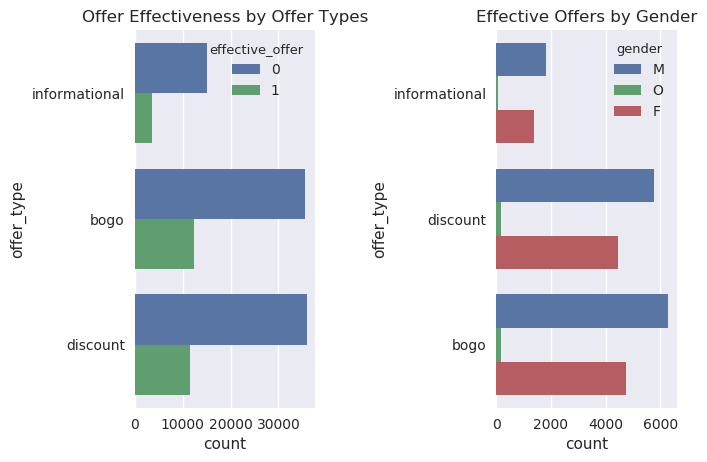

In [56]:
fig, ax =plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.0, hspace=None)
# Draw a nested barplot to show survival for class and sex
sns.countplot(y="offer_type",hue='effective_offer', data=offer_model, ax=ax[0]).set_title('Offer Effectiveness by Offer Types')
sns.countplot(y="offer_type",hue='gender', data=offer_model[offer_model['effective_offer']==1], ax=ax[1]).set_title('Effective Offers by Gender')

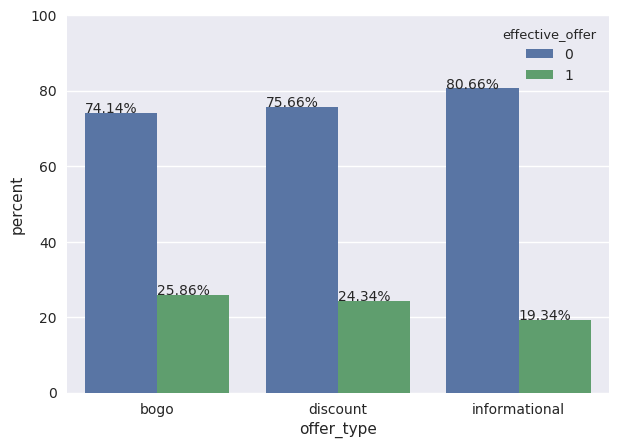

In [57]:
x,y = 'offer_type', 'effective_offer'

offer_counts = offer_model.groupby(x)[y].value_counts(normalize=True)
offer_counts = offer_counts.mul(100)
offer_counts = offer_counts.rename('percent').reset_index()

g = sns.barplot(x=x,y='percent',hue=y,data=offer_counts)
g.set_ylim(0,100)

for p in g.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)

### Effective Offers and customer Demographics :
Tuning the data set down to look into only effective offers , the observations still hold true in terms of BOGO offers having a slight edge over the discount offers , when we look into breakouts by Gender

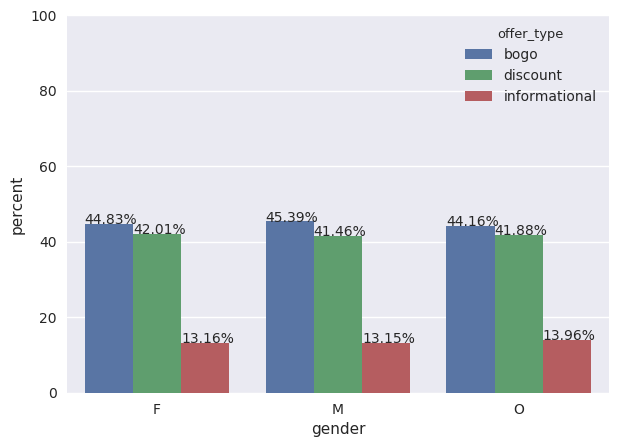

In [58]:
x,y = 'gender', 'offer_type'
df=offer_model[offer_model['effective_offer']==1]

offer_counts =df.groupby(x)[y].value_counts(normalize=True)
offer_counts = offer_counts.mul(100)
offer_counts = offer_counts.rename('percent').reset_index()

g = sns.barplot(x=x,y='percent',hue=y,data=offer_counts)
g.set_ylim(0,100)

for p in g.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)

gender  offer_type   
F       bogo             314067.66
        discount         425493.64
        informational     77765.12
M       bogo             300981.12
        discount         416591.07
        informational     76150.52
O       bogo               9490.15
        discount          13006.21
        informational      2576.76
Name: total_order_amount, dtype: float64


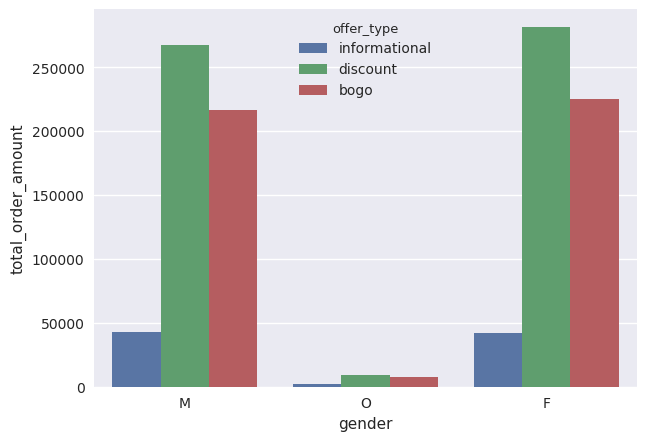

In [59]:
x,y = 'gender', 'total_order_amount'
df=offer_model[offer_model['effective_offer']==1]

ax = sns.barplot(x=x, y=y,hue='offer_type', data=df, ci=None, estimator=sum)
print(offer_model.groupby(['gender','offer_type'])['total_order_amount'].sum())

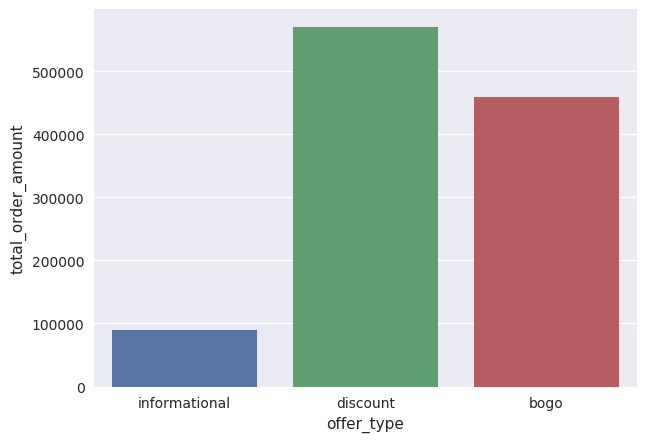

In [60]:
x,y = 'offer_type', 'total_order_amount'
df=offer_model[offer_model['effective_offer']==1]

ax = sns.barplot(x=x, y=y, data=df, ci=None, estimator=sum)

offer_type     effective_offer
bogo           0                  180335.11
               1                  458622.88
discount       0                  305060.86
               1                  570058.15
informational  0                   71153.04
               1                   89243.65
Name: total_order_amount, dtype: float64


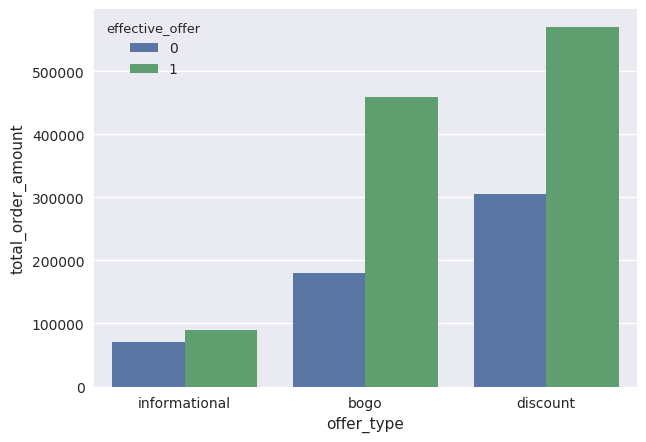

In [61]:
x,y = 'offer_type', 'total_order_amount'
ax = sns.barplot(x=x, y=y,hue='effective_offer', data=offer_model, ci=None, estimator=sum)
print(offer_model.groupby(['offer_type','effective_offer'])['total_order_amount'].sum())

### Effective Offers and Customer Income:

Looking further into whether income directly impacts purchase behavior of the customer. For a vast majority of the customers this does not have a strong correlation ~ 0.24 .

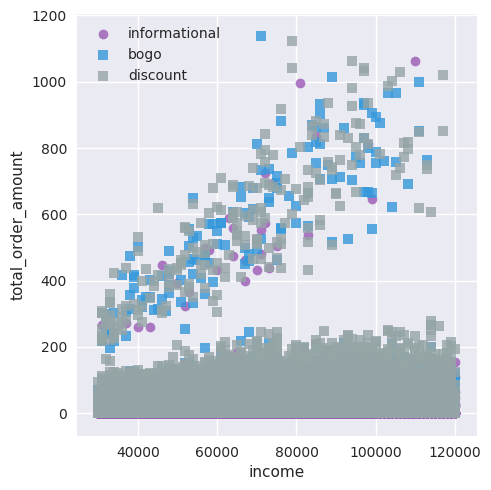

In [62]:
# Does Income have an effect on Order amount , by offer type category
sns.lmplot( x="income", y="total_order_amount", data=offer_model, fit_reg=False, hue='offer_type', legend=False,markers=["o", "s", ","],palette=dict(informational="#9b59b6", bogo="#3498db", discount="#95a5a6"))
plt.legend(loc='upper left')


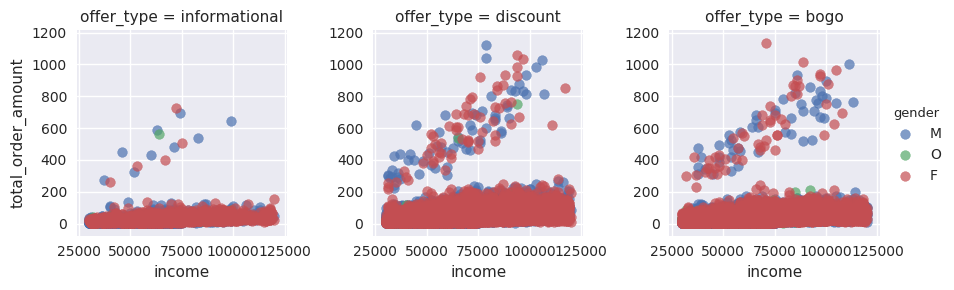

In [63]:
# Income ,Order by Gender
g = sns.FacetGrid(offer_model[offer_model['effective_offer']==1], col="offer_type", hue="gender")
g.map(plt.scatter, "income", "total_order_amount", alpha=.7)
g.add_legend();

In [64]:
offer_model[(offer_model['effective_offer']==1)&(offer_model['offer_type']=='informational')][['income','total_order_amount']].corr()

,income,total_order_amount
income,1.000000,0.239507
total_order_amount,0.239507,1.000000


In [65]:
offer_model[(offer_model['effective_offer']==1)&(offer_model['offer_type']=='discount')][['income','total_order_amount']].corr()

,income,total_order_amount
income,1.000000,0.246822
total_order_amount,0.246822,1.000000


In [66]:
offer_model[(offer_model['effective_offer']==1)&(offer_model['offer_type']=='bogo')][['income','total_order_amount']].corr()

,income,total_order_amount
income,1.000000,0.223714
total_order_amount,0.223714,1.000000


### Age vs Total Order amounts

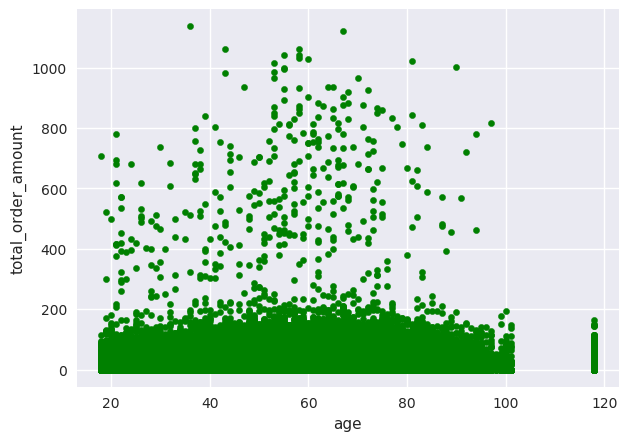

In [67]:
#Scatter plot order amount by age group
offer_model.plot(x='age',y='total_order_amount',kind='scatter',color='G',grid=True)

As seen from above chart - not a large proportion of purchases coming from the 118 age group.We can clean up the data set by removing records for these customers.

In [68]:
# Remove users with age more than 100
offer_model = offer_model.drop(offer_model[(offer_model.age >100) ].index)

In [69]:
#offers received per customer
offer_model[offer_model['offer_received']==1].groupby('customer_id').agg({"offer_id": "nunique"}).describe()

,offer_id
count,14815.000000
mean,3.726223
std,0.989535
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,6.000000


50th percentile = 4 offers per customer

In [167]:
offer_model['age'].describe()

count    101107.000000
mean         54.755566
std          17.202565
min          18.000000
25%          43.000000
50%          56.000000
75%          67.000000
max         100.000000
Name: age, dtype: float64

Age: 50th percentile >=56years 

### Effective Offers and Customer Age:
Purchases peak between 40 and 70 years of age ,with discount offers being the most popular offer that is redeemed.

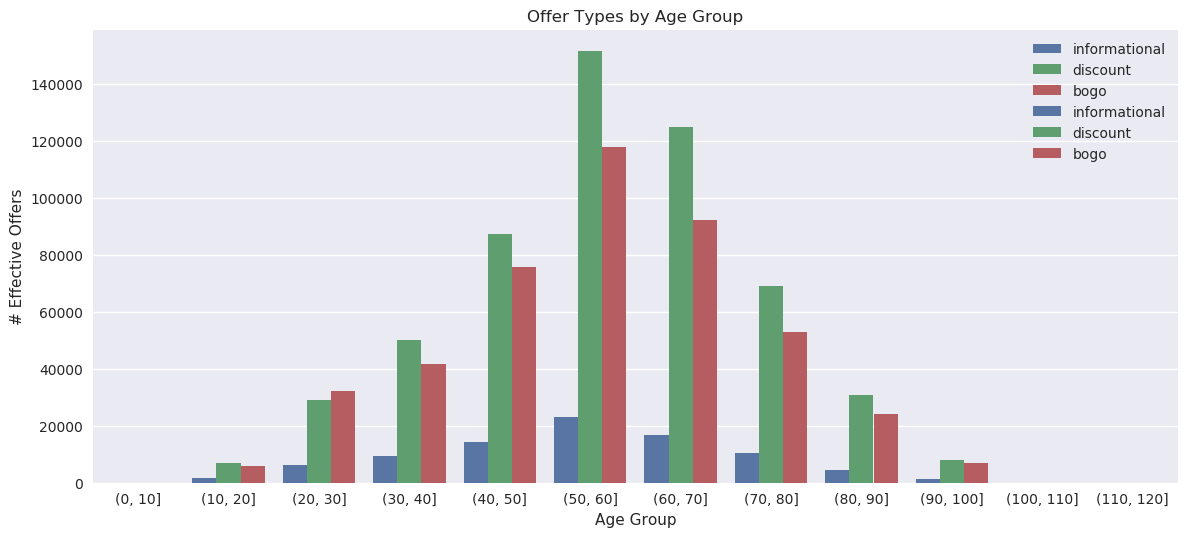

In [70]:
plt.figure(figsize=(14, 6))
sns.countplot(x="agegroup", hue="offer_type", data=offer_model[offer_model['effective_offer']==1])
x,y = 'agegroup', 'total_order_amount'
ax = sns.barplot(x=x, y=y,hue='offer_type', data=offer_model[offer_model['effective_offer']==1], ci=None, estimator=sum)
plt.title('Offer Types by Age Group')
plt.ylabel('# Effective Offers')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.legend(loc='upper right')
plt.show();

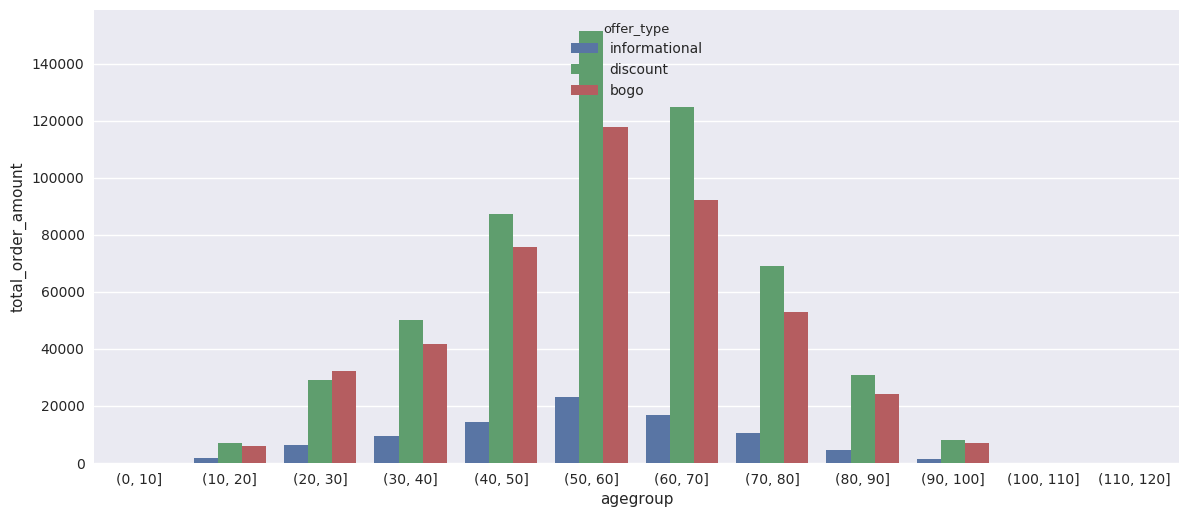

In [71]:
plt.figure(figsize=(14, 6))
x,y = 'agegroup', 'total_order_amount'
ax = sns.barplot(x=x, y=y,hue='offer_type', data=offer_model[offer_model['effective_offer']==1], ci=None, estimator=sum)

In [144]:
# create a separate encoding for offer_id and gender
offer_model['offer'] = offer_model.offer_id.astype('category').cat.codes
offer_model['id'] = offer_model.customer_id.astype('category').cat.codes
columns = ['gender']
offer_model['age_group'] = offer_model.agegroup.astype('category').cat.codes

offer_model = column_values_encode(offer_model, columns)
#Consolidate into single record per user offer , if user reponded positively to an offer - that is credited as an effective offer
offer_model_df=offer_model.groupby(['id','F','M','O','income','offer','customer_id','offer_id','duration','offer_type','age_group'])['effective_offer'].max().reset_index()

#offer_model_df=offer_model[['effective_offer','id','F','M','O','income','offer','customer_id','offer_id','duration','offer_type','age_group']]
offer_model_df.head(23)

,id,F,M,O,income,offer,customer_id,offer_id,duration,offer_type,age_group,effective_offer
0,0,0,1,0,72000.0,2,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,7,discount,3,0
1,0,0,1,0,72000.0,3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4,informational,3,1
2,0,0,1,0,72000.0,5,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3,informational,3,1
3,0,0,1,0,72000.0,8,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5,bogo,3,0
4,0,0,1,0,72000.0,9,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10,discount,3,0
5,2,0,0,1,57000.0,0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,discount,3,1
6,2,0,0,1,57000.0,1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,discount,3,1
7,2,0,0,1,57000.0,3,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,4,informational,3,0
8,2,0,0,1,57000.0,5,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,3,informational,3,0
9,2,0,0,1,57000.0,6,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,bogo,3,1


In [147]:
#Validate if there any duplicate records for customer offer combination
offer_model_df["RANK"] = offer_model_df.groupby(['id','offer'])["id"].rank(method="first", ascending=True)
offer_model_df[offer_model_df["RANK"]>1]

,id,F,M,O,income,offer,customer_id,offer_id,duration,offer_type,age_group,effective_offer,RANK


In [148]:
offer_model_df.describe()

,id,F,M,O,income,offer,duration,age_group,effective_offer,RANK
count,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.0
mean,8502.924469,0.413024,0.573051,0.013926,65388.595125,4.496831,6.508239,4.883706,0.450292,1.0
std,4906.739004,0.492381,0.494639,0.117183,21626.373809,2.874461,2.205656,1.766596,0.497527,0.0
min,0.000000,0.000000,0.000000,0.000000,30000.000000,0.000000,3.000000,1.000000,0.000000,1.0
25%,4258.000000,0.000000,0.000000,0.000000,49000.000000,2.000000,5.000000,4.000000,0.000000,1.0
50%,8509.000000,0.000000,1.000000,0.000000,63000.000000,5.000000,7.000000,5.000000,0.000000,1.0
75%,12742.000000,1.000000,1.000000,0.000000,80000.000000,7.000000,7.000000,6.000000,1.000000,1.0
max,16993.000000,1.000000,1.000000,1.000000,120000.000000,9.000000,10.000000,10.000000,1.000000,1.0


In [149]:
offer_model_df.corr()

,id,F,M,O,income,offer,duration,age_group,effective_offer,RANK
id,1.000000,-0.007919,0.008178,-0.001247,-0.015154,0.001725,-0.002931,0.003939,0.008204,NaN
F,-0.007919,1.000000,-0.971819,-0.099685,0.226005,-0.002517,-0.002683,0.143201,0.024450,NaN
M,0.008178,-0.971819,1.000000,-0.137677,-0.221714,0.002557,0.003067,-0.143220,-0.027850,NaN
O,-0.001247,-0.099685,-0.137677,1.000000,-0.013761,-0.000218,-0.001670,0.002837,0.014824,NaN
income,-0.015154,0.226005,-0.221714,-0.013761,1.000000,0.001218,-0.001160,0.299159,0.016836,NaN
offer,0.001725,-0.002517,0.002557,-0.000218,0.001218,1.000000,-0.055583,0.002071,0.187581,NaN
duration,-0.002931,-0.002683,0.003067,-0.001670,-0.001160,-0.055583,1.000000,-0.001790,0.046967,NaN
age_group,0.003939,0.143201,-0.143220,0.002837,0.299159,0.002071,-0.001790,1.000000,0.006279,NaN
effective_offer,0.008204,0.024450,-0.027850,0.014824,0.016836,0.187581,0.046967,0.006279,1.000000,NaN
RANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modeling 
 Given a specific set of demographic data , can we predict whether an offer will be effective ?

#### Prepare data set for modeling

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# input variables -
#age ,income,gender,membership duration,offer_type

#predict : offer_view_before_pay

def clean_data(offer_model_df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Creating model dataframe
    offer_model_df=offer_model_df[['effective_offer','id','F','M','O','income','age_group','offer','duration']]
    y = offer_model_df['effective_offer']
    
    #Drop 'offer_view_before_pay' columns
    df = offer_model_df.drop(['effective_offer'], axis=1)
    
        
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(offer_model_df)    



In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Decision Tree Classifier

In [152]:
## Run Multiple models
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3716 2328]
 [2338 2663]]
             precision    recall  f1-score   support

          0       0.61      0.61      0.61      6044
          1       0.53      0.53      0.53      5001

avg / total       0.58      0.58      0.58     11045



In [153]:
print(sum(y_pred)/len(y_pred))
print(y_test.sum()/y_test.shape[0])

0.451878678135
0.452784065188


## Evaluate Multiple Models

In [180]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', LogisticRegression()) #step2 - classifier
])
pipeline.steps

clfs = []
clfs.append(LogisticRegression())
clfs.append(KNeighborsClassifier(n_neighbors=5))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier(random_state=42))

for classifier in clfs:
    pipeline.set_params(clf = classifier)
    print('******************************')
    print(str(classifier))
    print('------------------------------')
    scores = cross_validate(pipeline, X_train, y_train, scoring='f1_weighted')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

******************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
------------------------------
fit_time  mean  0.0550083319346
fit_time  std  0.000860730835421
score_time  mean  0.00542267163595
score_time  std  0.00019947304665
test_score  mean  0.594501084935
test_score  std  0.00243994637339
train_score  mean  0.594895511656
train_score  std  0.00195443453566
******************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
------------------------------
fit_time  mean  1.10820849737
fit_time  std  0.0159424167477
score_time  mean  1.16538262367
score_time  std  0.00481311341567
test_score  mean  0.607241643797
test_score  std  

### Random Forest Classifier

In [ ]:

model_params = { 
    'n_estimators': randint(4,200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8],
}

In [156]:

rfc=RandomForestClassifier(random_state=42)
CV_rfc = RandomizedSearchCV(rfc, model_params,n_jobs=-1,n_iter=100, cv=3,scoring='f1_weighted', random_state=42, verbose=10)
model=CV_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] max_depth=8, max_features=auto, n_estimators=18 .................
[CV]  max_depth=8, max_features=auto, n_estimators=18, score=0.6537166551901274, total=   0.4s
[CV] max_depth=8, max_features=auto, n_estimators=18 .................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=8, max_features=auto, n_estimators=18, score=0.6536376752613695, total=   0.4s
[CV] max_depth=8, max_features=auto, n_estimators=18 .................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=8, max_features=auto, n_estimators=18, score=0.6502159165581751, total=   0.4s
[CV] max_depth=8, max_features=auto, n_estimators=24 .................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=8, max_features=auto, n_estimators=24, score=0.6554547478606864, total=   0.5s
[CV] max_depth=8, max_features=auto, n_estimators=24 .................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s


[CV]  max_depth=8, max_features=auto, n_estimators=24, score=0.650683408947549, total=   0.5s
[CV] max_depth=8, max_features=auto, n_estimators=24 .................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s


[CV]  max_depth=8, max_features=auto, n_estimators=24, score=0.650121508340483, total=   0.5s
[CV] max_depth=8, max_features=sqrt, n_estimators=78 .................


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.3s remaining:    0.0s


[CV]  max_depth=8, max_features=sqrt, n_estimators=78, score=0.6562053555502291, total=   1.8s
[CV] max_depth=8, max_features=sqrt, n_estimators=78 .................


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    5.3s remaining:    0.0s


[CV]  max_depth=8, max_features=sqrt, n_estimators=78, score=0.6564277645275917, total=   1.7s
[CV] max_depth=8, max_features=sqrt, n_estimators=78 .................


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    7.3s remaining:    0.0s


[CV]  max_depth=8, max_features=sqrt, n_estimators=78, score=0.6501777313864913, total=   1.7s
[CV] max_depth=8, max_features=auto, n_estimators=103 ................


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    9.3s remaining:    0.0s


[CV]  max_depth=8, max_features=auto, n_estimators=103, score=0.6570391427411054, total=   2.3s
[CV] max_depth=8, max_features=auto, n_estimators=103 ................
[CV]  max_depth=8, max_features=auto, n_estimators=103, score=0.6566471017011475, total=   2.2s
[CV] max_depth=8, max_features=auto, n_estimators=103 ................
[CV]  max_depth=8, max_features=auto, n_estimators=103, score=0.6501585548828472, total=   2.3s
[CV] max_depth=8, max_features=sqrt, n_estimators=56 .................
[CV]  max_depth=8, max_features=sqrt, n_estimators=56, score=0.6585580873459659, total=   1.3s
[CV] max_depth=8, max_features=sqrt, n_estimators=56 .................
[CV]  max_depth=8, max_features=sqrt, n_estimators=56, score=0.6541799509970909, total=   1.2s
[CV] max_depth=8, max_features=sqrt, n_estimators=56 .................
[CV]  max_depth=8, max_features=sqrt, n_estimators=56, score=0.6488445912359239, total=   1.3s
[CV] max_depth=6, max_features=sqrt, n_estimators=41 .................
[

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.8min finished


In [157]:
CV_rfc.best_params_

{'max_depth': 8, 'max_features': 'log2', 'n_estimators': 187}

In [158]:
pred=CV_rfc.predict(X_test)

In [178]:
print("% of Positive Predictions :", sum(pred)/len(pred))
print("% of Positive Actuals :" ,y_test.sum()/y_test.shape[0])

% of Positive Predictions : 0.467904028972
% of Positive Actuals : 0.452784065188


## Model Evaulation

In [161]:

def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [162]:
evaluate_model_performance(CV_rfc.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.674
RandomForestClassifier model f1-score: 0.641


(0.67354053014011817, 0.64094009859084788)

In [163]:
evaluate_model_performance(CV_rfc.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.666
RandomForestClassifier model f1-score: 0.637


(0.66582163875056588, 0.63703412331596021)

In [172]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_dist = dict(n_neighbors=k_range, weights=weight_options)
knnc=KNeighborsClassifier(n_neighbors=13, weights='uniform')
CV_knnc = RandomizedSearchCV(knnc, param_dist,cv=5, scoring='f1_weighted', n_iter=10, random_state=5, verbose=10)

model_2=CV_knnc.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] weights=distance, n_neighbors=16 ................................
[CV]  weights=distance, n_neighbors=16, score=0.54337069499404, total=   0.1s
[CV] weights=distance, n_neighbors=16 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  weights=distance, n_neighbors=16, score=0.5401969443186962, total=   0.1s
[CV] weights=distance, n_neighbors=16 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  weights=distance, n_neighbors=16, score=0.540055502793101, total=   0.1s
[CV] weights=distance, n_neighbors=16 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


[CV]  weights=distance, n_neighbors=16, score=0.5450475965370485, total=   0.1s
[CV] weights=distance, n_neighbors=16 ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s


[CV]  weights=distance, n_neighbors=16, score=0.5447412403138542, total=   0.1s
[CV] weights=uniform, n_neighbors=22 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=22, score=0.5079910889014915, total=   0.4s
[CV] weights=uniform, n_neighbors=22 .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.1s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=22, score=0.5168672876102934, total=   0.4s
[CV] weights=uniform, n_neighbors=22 .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.8s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=22, score=0.5164471877975708, total=   0.4s
[CV] weights=uniform, n_neighbors=22 .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.5s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=22, score=0.5121179806585429, total=   0.4s
[CV] weights=uniform, n_neighbors=22 .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.2s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=22, score=0.5120761108652563, total=   0.4s
[CV] weights=uniform, n_neighbors=18 .................................
[CV]  weights=uniform, n_neighbors=18, score=0.5085140031569824, total=   0.4s
[CV] weights=uniform, n_neighbors=18 .................................
[CV]  weights=uniform, n_neighbors=18, score=0.5109010267393589, total=   0.4s
[CV] weights=uniform, n_neighbors=18 .................................
[CV]  weights=uniform, n_neighbors=18, score=0.5161924595723871, total=   0.4s
[CV] weights=uniform, n_neighbors=18 .................................
[CV]  weights=uniform, n_neighbors=18, score=0.513409821243691, total=   0.4s
[CV] weights=uniform, n_neighbors=18 .................................
[CV]  weights=uniform, n_neighbors=18, score=0.5156420535454512, total=   0.4s
[CV] weights=uniform, n_neighbors=27 .................................
[CV]  weights=uniform, n_neighbors=27, score=0.5166970766504576, total=   0.4s
[CV] weights=uniform, 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.0min finished


In [174]:
# examine the best model
print(model_2.best_score_)
print(model_2.best_params_)
print(model_2.best_estimator_)

0.542980729264
{'weights': 'distance', 'n_neighbors': 10}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')


In [175]:
evaluate_model_performance(CV_knnc.best_estimator_, X_train, y_train)

KNeighborsClassifier model accuracy: 1.000
KNeighborsClassifier model f1-score: 1.000


(1.0, 1.0)

In [176]:
evaluate_model_performance(CV_knnc.best_estimator_, X_test, y_test)

KNeighborsClassifier model accuracy: 0.552
KNeighborsClassifier model f1-score: 0.486


(0.55192394748755091, 0.48645844142367956)